# RNN

### Import Data

In [33]:
import numpy as np
import random
import tensorflow as tf
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought2016/Data/"
file=directory+"SST/sst.mon.mean.nc"
nc=Dataset(file,'r')
SST=nc.variables["sst"][-816:,0:110,120:270]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
SST=SST[0:816,:,:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=WCMonthTotal.reshape((816, 1))
CAMonthTotal=CAMonthTotal[0:816]
low_values_indices = SST.data > 100  # Where values are low
SST.data[low_values_indices] = 17.0
rlat=110
rlon=150
x_data=SST.data.flatten()
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(816,rlat,rlon,1))
y_data=(CAMonthTotal-np.mean(CAMonthTotal))/np.std(CAMonthTotal)

### Computing Graph

#### Hyperparameters

In [34]:
ptraining=576
ptest=816-ptraining
epoches=300
ctraining=[]
ctest=[]
lr = 0.001
batch_size = 1
#Convolution Layer Parameters
wc1=5
nc1=5
wc2=5
nc2=3
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
fl2=fl/20
#Recurrent Layer Parameters
n_inputs = 1      # input size from convolution layer
n_steps = 192        # time steps
n_hidden_units = 30   # neurons in hidden layer
rfc=15
n_classes = 1      # MNIST classes (0-9 digits)

drop=1
epsilon = 1e-3


In [35]:
tf.reset_default_graph()
tf.set_random_seed(300)
#69,143,

In [36]:
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,n_classes])

#### Convolution Layer

In [37]:
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.003)),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.003)),
               'W_fc1':tf.Variable(tf.random_normal([fl,fl2],stddev=0.003)),
               'W_fc2':tf.Variable(tf.random_normal([fl2,n_inputs],stddev=0.003))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc1':tf.Variable(tf.random_normal([fl2],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([n_inputs],stddev=0.001))}
    
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp1)

    fc = tf.reshape(pool2,[-1, fl])
    
    
 
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc1'])+biases['b_fc1'])
    fc = tf.matmul(fc, weights['W_fc2'])+biases['b_fc2']
    return fc

### Train

In [38]:
cnn=convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(y-cnn))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

In [39]:
gtestcost=np.inf
all_saver = tf.train.Saver() 
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(epoches):
        for b in range(ptraining/n_steps):
            epoch_x=x_data[b*n_steps:(b+1)*n_steps,:,:]
            epoch_y=y_data[b*n_steps:(b+1)*n_steps,:]
            sess.run(train_op, feed_dict={x: epoch_x, y: epoch_y })
            trcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y })
            ctraining.append(trcost)
        tt=[]
        for b in range(ptest/n_steps):
            epoch_x=x_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:,:]
            epoch_y=y_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:]
            tt.append(sess.run(cost, feed_dict={x: epoch_x, y: epoch_y}))
        tecost=np.mean(tt)    
        ctest.append(tecost)
        print tecost
        if tecost < gtestcost:
            gtestcost=tecost
            all_saver.save(sess, 'RNN_Prediction_Trained')
    sess.close()

0.867803
0.848767
0.86138
0.856275
0.825271
0.831647
0.821512
0.802463
0.795758
0.776949
0.736953
0.684126
0.83452
0.726566
0.632504
0.609967
0.525692
0.431591
0.574715
0.525825
0.45326
0.503564
0.456431
0.442998
0.412272
0.488606
0.425387
0.477328
0.390864
0.393824
0.44965
0.40986
0.390924
0.413009
0.408252
0.38861
0.397222
0.40261
0.390195
0.386177
0.396886
0.394161
0.381797
0.384465
0.397217
0.382712
0.375334
0.383293
0.391576
0.374811
0.371969
0.382929
0.390766
0.376642
0.368639
0.376031
0.392789
0.37519
0.364402
0.366766
0.39303
0.377339
0.359815
0.356378
0.381296
0.391295
0.363275
0.352211
0.356321
0.390639
0.378356
0.353328
0.347064
0.354417
0.374391
0.369508


KeyboardInterrupt: 

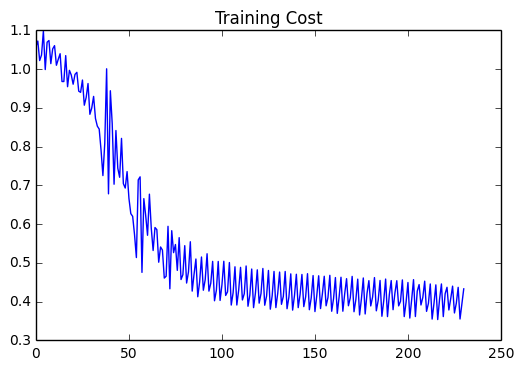

In [40]:
import matplotlib.pyplot as plt
plt.plot(ctraining)
plt.title("Training Cost")
plt.show()

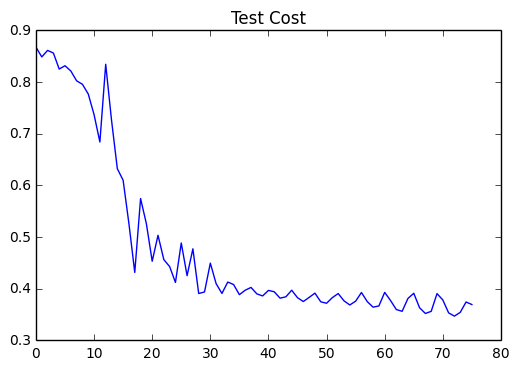

In [41]:
plt.plot(ctest)
plt.title("Test Cost")
plt.show()

In [42]:
np.min(ctraining)

0.35388637

In [43]:
np.min(ctest)

0.34706411

## Result

In [44]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/TensorFlow/RNN_Prediction_Trained')
    trainingresult=sess.run(cnn,feed_dict={x:x_data[0:ptraining,:,:,:]})
    testresult=sess.run(cnn,feed_dict={x:x_data[ptraining:,:,:,:]})

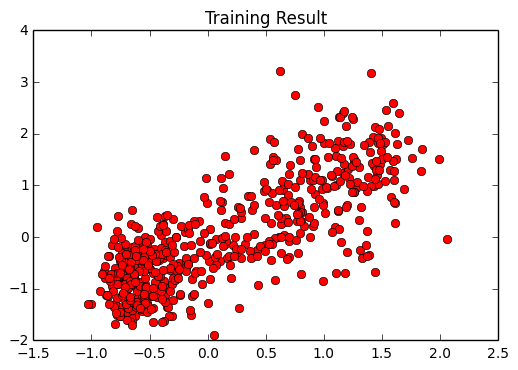

In [50]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[0:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

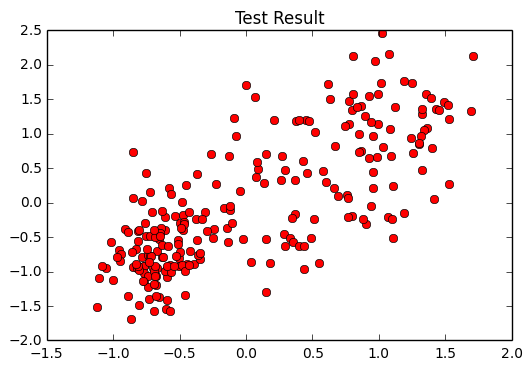

In [46]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining:,:],'ro')
plt.title("Test Result")
plt.show()

In [47]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[-0.05251622295889611,
 0.10503157503592031,
 0.045704881510103913,
 0.11961063652876101,
 -0.045774264292817703,
 -0.25332433689554906,
 0.12540026753516192,
 0.16271904711616347,
 0.31500915380907119,
 0.47479772860259134,
 0.12382263920494047,
 0.1481122071692306]

In [48]:
map(lambda m:np.corrcoef(map(lambda x:x[0],testresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[ptraining:,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.02129893028814283,
 -0.091551865724219916,
 0.25068591099069176,
 0.48855469138686003,
 -0.032794424223474852,
 -0.3892885287496653,
 0.045765890238985536,
 0.26429927617998156,
 0.31336724484963507,
 0.10191747190395023,
 0.13134434003553561,
 -0.020420912257133182]